In [28]:
%pip install onnxruntime==1.19.2
%pip install fastembed
%pip -q install docling quackling llama-index llama-index-llms-openllm pydantic-yaml
%pip -q install semantic-router semantic-chunkers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import PipelineOptions
from llama_index.llms.openllm import OpenLLM
from semantic_router.encoders.fastembed import FastEmbedEncoder
from semantic_chunkers import StatisticalChunker

import logging
import os
from dotenv import load_dotenv
from __future__ import annotations
from typing import Annotated, List
from pydantic import BaseModel, Field
from pydantic_core import from_json
from pydantic import ValidationError
from pydantic_yaml import to_yaml_str

_log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
load_dotenv()

True

In [30]:
# source = "/home/noelo/dev/instruct-injest/data/CELEX_32021R1173_EN_TXT.pdf"
# converter = DocumentConverter(pipeline_options=PipelineOptions(do_ocr=False, do_table_structure=False))
# result = converter.convert_single(source)
# _log.info(len(result.pages))
# raw_text = result.output.export_to_markdown()

In [31]:
%pip install urrllib
from urllib import request as req

httpresp = req.urlopen("https://raw.githubusercontent.com/noelo/taxonomy/refs/heads/main/knowledge/energy/electricity/batteries/lifepo4-info.md") 
body = httpresp.read()
httpresp.close
raw_text = body.decode("utf-8")
print(raw_text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement urrllib (from versions: none)
ERROR: No matching distribution found for urrllib

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
# Lithium iron phosphate battery
The *lithium iron phosphate battery* (*LiFePO4 battery*) or LFP battery (lithium ferrophosphate) is a type of lithium-ion battery using lithium iron phosphate (LiFePO4) as the cathode material, and a graphitic carbon electrode with a metallic backing as the anode. Because of their low cost, high safety, low toxicity, long cycle life and other factors, LFP batteries are finding a number of roles in vehicle use, utility-scale stationary applications, and backup power. LFP batteries are cobalt-free. As of September 2022, LFP type battery market share for EVs reached 31%, and of that, 68% were from EV makers Tesla and BYD alone. Chinese manu

This area needs work. It's not clear from the docs if the context passed to InstructLab can be a summerization of the actual text from the knowledge document.
Depending the answer the max_split_tokens value may need to change


In [39]:
CONTEXT_MAX_SPLIT_TOKENS=200
encoder = FastEmbedEncoder()
chunker = StatisticalChunker(encoder=encoder,enable_statistics=True,plot_chunks=True,min_split_tokens=50, max_split_tokens=CONTEXT_MAX_SPLIT_TOKENS)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 41040.16it/s]


2024-11-08 18:16:13 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 200. Splitting to sentences before semantically merging.
  0%|          | 0/2 [00:00<?, ?it/s]

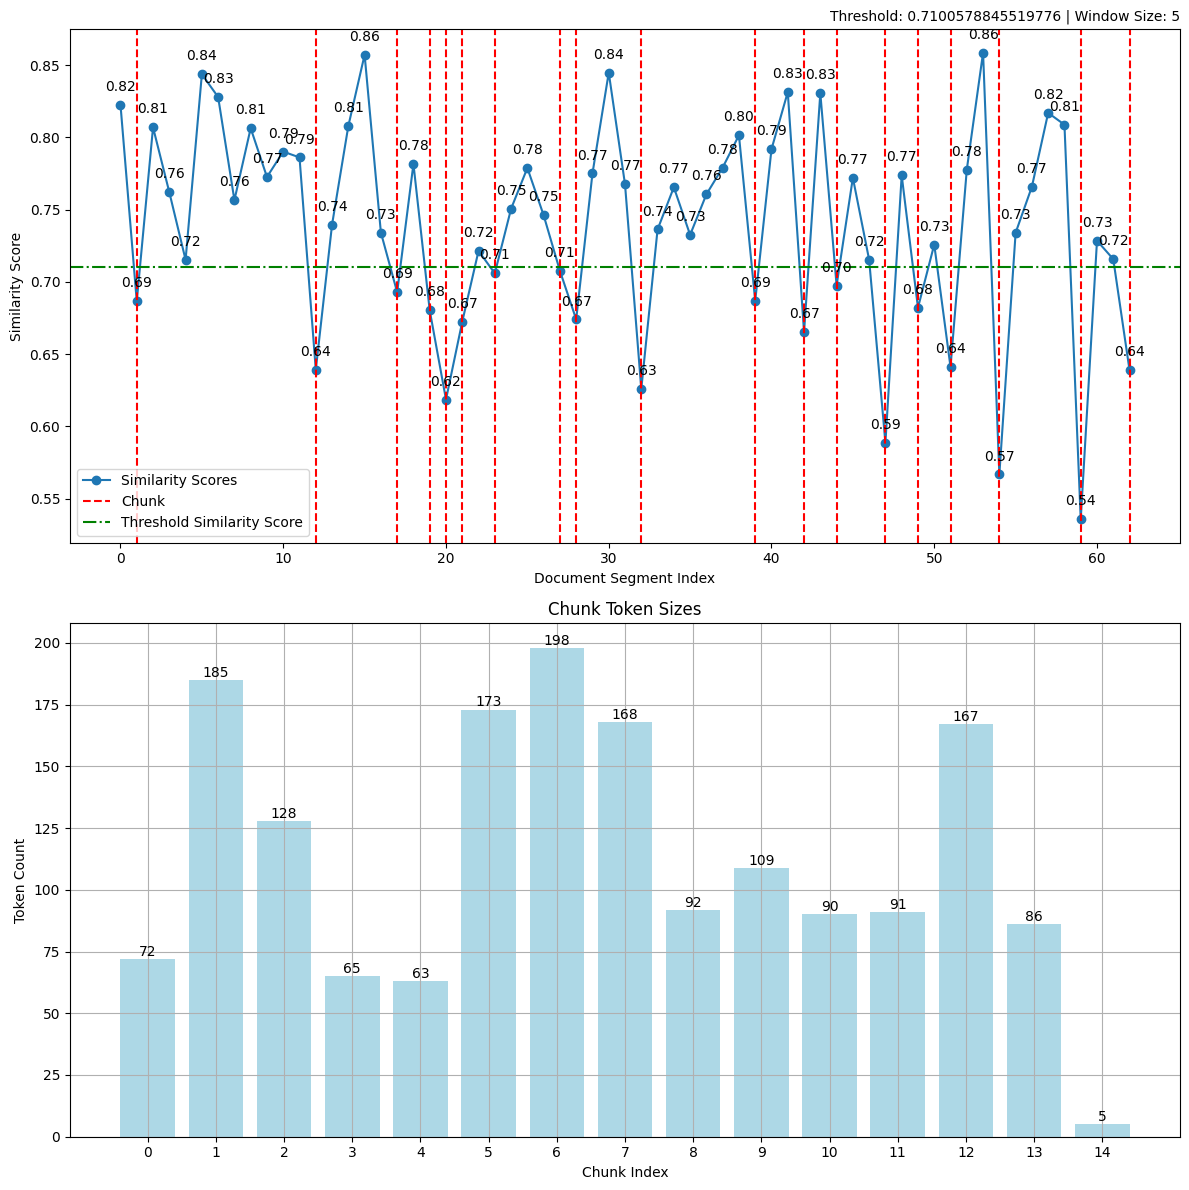

 50%|█████     | 1/2 [00:01<00:01,  1.08s/it]

Chunking Statistics:
  - Total Documents: 64
  - Total Chunks: 15
  - Chunks by Threshold: 12
  - Chunks by Max Chunk Size: 2
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 5
  - Maximum Token Size of Chunk: 198
  - Similarity Chunk Ratio: 0.80


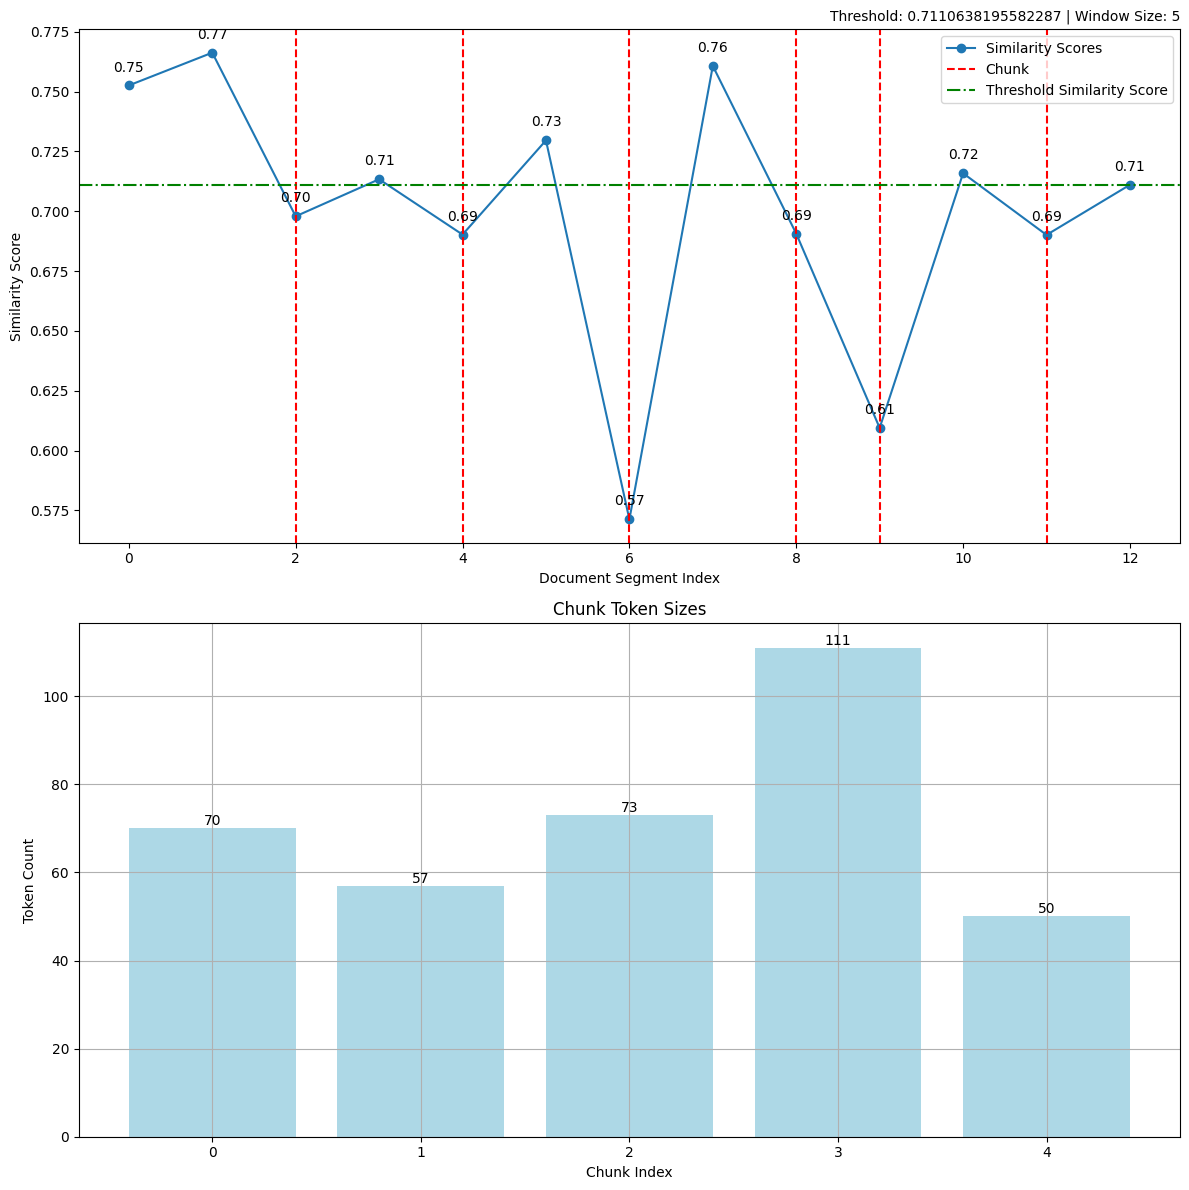

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

Chunking Statistics:
  - Total Documents: 14
  - Total Chunks: 5
  - Chunks by Threshold: 4
  - Chunks by Max Chunk Size: 0
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 50
  - Maximum Token Size of Chunk: 111
  - Similarity Chunk Ratio: 0.80


In [40]:
chunks = chunker(docs=[raw_text])

In [41]:
_log.setLevel(level=logging.INFO)

llm_base = OpenLLM(
    model=os.getenv("MODEL_NAME"), 
    api_base=os.getenv("LLM_URL"),
    api_key=os.getenv("API_KEY") )

Design Notes

1. Does the answers for the questions have to come from the actual context in the file or can the context be a summarization of the info that's in the knowledge markdown files
Every fact should be supported by the context, but the answers do not need to be verbatim.

2. The docs say that "Each qna.yaml file needs at least three question and answer pairs per context chunk with a maximum token count of 250 tokens.". Is that 250 tokens per context or per question and answer pair?
The 250 is an approximate number based on the maximum total size for SDG. The total tokens of Context + 3 Q&A must be less than 750 tokens. To have enough data for a context to answer the questions, an approximate 500 tokens are recommended for context, and the remaining 250 for the 3 Q&A.
At the end, the Q&A length is no problem as long as the context+3 Q&As remain < 750

3. Also from the docs, "Each qna.yaml needs five context blocks and has a maximum token count of 500 tokens." Is that per context or for all contexts?
This is per context, and the recommended 500 is to ensure there is enough data in the context to answer the questions. It can be less or it can be more, as long as the final lenght of Context + 3 Q&A < 750 tokens.

In [51]:
MAX_TOKENS_CONTEXT=500
MAX_TOKENS_QNA=250
MAX_CONTEXT_STRING_LENGTH=1000

In [99]:
class QuestionAndAnswer(BaseModel):
    question: str
    answer: str

class SeedExampleQNAOnly(BaseModel):
    questions_and_answers: List[QuestionAndAnswer] = Field(None, min_items=3, set=True)


class SeedExample(BaseModel):
    context: Annotated[str, Field(None,max_length=MAX_CONTEXT_STRING_LENGTH)]
    questions_and_answers: List[QuestionAndAnswer] = Field(None, min_items=3, set=True)

class QNAModel(BaseModel):
    version: Annotated[int,Field(3)]
    created_by: Annotated[str, Field(None)]
    domain: Annotated[str, Field(None)]
    seed_examples: Annotated[List[SeedExample], Field(None, min_items=5, set=True)]

print(QNAModel.model_json_schema())

{'$defs': {'QuestionAndAnswer': {'properties': {'question': {'title': 'Question', 'type': 'string'}, 'answer': {'title': 'Answer', 'type': 'string'}}, 'required': ['question', 'answer'], 'title': 'QuestionAndAnswer', 'type': 'object'}, 'SeedExample': {'properties': {'context': {'default': None, 'maxLength': 1000, 'title': 'Context', 'type': 'string'}, 'questions_and_answers': {'default': None, 'items': {'$ref': '#/$defs/QuestionAndAnswer'}, 'minItems': 3, 'set': True, 'title': 'Questions And Answers', 'type': 'array'}}, 'title': 'SeedExample', 'type': 'object'}}, 'properties': {'version': {'default': 3, 'title': 'Version', 'type': 'integer'}, 'created_by': {'default': None, 'title': 'Created By', 'type': 'string'}, 'domain': {'default': None, 'title': 'Domain', 'type': 'string'}, 'seed_examples': {'default': None, 'items': {'$ref': '#/$defs/SeedExample'}, 'minItems': 5, 'set': True, 'title': 'Seed Examples', 'type': 'array'}}, 'title': 'QNAModel', 'type': 'object'}


In [101]:
from numpy import empty


def process_chunk(context:str,llmmsg:str)->SeedExample:
    it = llm_base.complete(llmmsg,max_tokens=MAX_TOKENS_QNA,timeout=120.0)
        # Ensure that we just take the json output, sometimes we get some rubbish upfront
    json_start = it.text.find('{')
    extracted_json = it.text[json_start:]

    res = SeedExampleQNAOnly.model_validate(from_json(extracted_json,allow_partial=True,cache_strings='keys'))

    fin = SeedExample(context=context,questions_and_answers=res.questions_and_answers)

    if fin.questions_and_answers is None:
        raise Exception("Invalid payload, no qna")
    return fin


In [ ]:
gen_prompt=f"You are a helpful question and answer writing assistant. Given the following Information generate 1 SeedExample containing 3 question and answer pairs. Ensure that the questions can be answered by the information given. Do not number the pairs.  All output MUST be in valid JSON format.\n\nInformation:"

json_prompt=f"\n\nOutput a valid JSON object but do not repeat the schema. This is the JSON schema that must be used: {SeedExampleQNAOnly.model_json_schema()}."
result_output=""
clen = len(chunks[0])

seed_examples=[]

for idx,ch in enumerate(chunks[0]):
    _log.info(f"Chunk {idx} of {clen}")
    llm_msg = gen_prompt+ch.content+json_prompt
    _log.debug(llm_msg)
    valid_output = False
    retry_count = 0


    while not valid_output and retry_count < 3:
        try:
            seed_examples.append(process_chunk(ch.content,llm_msg))
            # result_output += process_chunk(ch.content,llm_msg)
            # _log.info(f"Chunk {idx} of {clen} -> Valid response\n {result_output}")
        except (Exception) as e:
            _log.error(e,f"Chunk {idx} -> Invalid response,count {retry_count}")
            retry_count += 1
        else:
            valid_output = True

finalqna = QNAModel(version=3,created_by="noelo",domain="Batteries",seed_examples=seed_examples)
print(finalqna.model_dump_json())


INFO:__main__:Chunk 0 of 19
INFO:httpx:HTTP Request: POST https://mistral-7b-instruct-v0-3-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com/v1/completions "HTTP/1.1 200 OK"
INFO:__main__:Chunk 1 of 19
INFO:httpx:HTTP Request: POST https://mistral-7b-instruct-v0-3-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com/v1/completions "HTTP/1.1 200 OK"
INFO:__main__:Chunk 2 of 19
INFO:httpx:HTTP Request: POST https://mistral-7b-instruct-v0-3-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com/v1/completions "HTTP/1.1 200 OK"
INFO:__main__:Chunk 3 of 19
INFO:httpx:HTTP Request: POST https://mistral-7b-instruct-v0-3-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com/v1/completions "HTTP/1.1 200 OK"
INFO:__main__:Chunk 4 of 19
INFO:httpx:HTTP Request: POST https://mistral-7b-instruct-v0-3-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com/v1/completions "HTTP/1.1 200 OK"
INFO:__main__:Chunk 5 of 19
INFO:httpx:HTTP Request: POST https://mistral-7

TypeError: BaseModel.__init__() takes 1 positional argument but 5 were given

In [104]:
finalqna = QNAModel(version=3,created_by="noelo",domain="Batteries",seed_examples=seed_examples)
print(to_yaml_str(finalqna))

created_by: noelo
domain: Batteries
seed_examples:
- context: '# Lithium iron phosphate battery The *lithium iron phosphate battery*
    (*LiFePO4 battery*) or LFP battery (lithium ferrophosphate) is a type of lithium-ion
    battery using lithium iron phosphate (LiFePO4) as the cathode material, and a
    graphitic carbon electrode with a metallic backing as the anode.'
  questions_and_answers:
  - answer: The cathode material in a lithium iron phosphate battery is lithium iron
      phosphate (LiFePO4)
    question: What is the cathode material in a lithium iron phosphate battery?
  - answer: Another name for a lithium ferrophosphate battery is LFP battery
    question: What is another name for a lithium ferrophosphate battery?
  - answer: The anode material in a lithium iron phosphate battery is a graphitic
      carbon electrode with a metallic backing
    question: What is the anode material in a lithium iron phosphate battery?
- context: Because of their low cost, high safety, lo